# Features after Manufacturing

Comparison across two different datasets.

Andrew Weng

9/20/2020

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import pandas as pd
import yaml
import seaborn as sns

from scipy import stats, interpolate
from matplotlib import pyplot as plt

from src.utils import get_label_registry
import src.plotter as plotter

import warnings
warnings.filterwarnings('ignore')

In [2]:
plotter.initialize(plt)
paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)
output_path = f"{paths['outputs']}/2022-08-25-manufacturing-features"

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

# Load the correlation data

Augment the output table with some additional parameters derived from the original (e.g. converting absolute capacities to areal capacities)

In [3]:
paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)

# Weng2021 dataset
path = paths['outputs'] + 'summary_esoh_table.csv'
df_weng2021 = pd.read_csv(path)
df_weng2021 = df_weng2021[df_weng2021['cycle_number'] == 3]
df_weng2021.head()

# Label by test temperature
for i, row in df_weng2021.iterrows():
    if row['cellid'] in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]:
        df_weng2021.at[i, 'Source'] = 'Weng2021 (HT)'
    else:
        df_weng2021.at[i, 'Source'] = 'Weng2021 (RT)'
df_weng2021['pos_area_cm2'] = 7 * 2 * 7.2 * 11
df_weng2021['neg_area_cm2'] = 7 * 2 * (7.2+0.02) * (11+0.02)
df_weng2021['pos_loading_mg_cm2'] = 17.225 # single side
df_weng2021['neg_loading_mg_cm2'] = 7.85   # single side
df_weng2021['pos_active_frac'] = 0.94
df_weng2021['neg_active_frac'] = 0.97

# Mohtat2021 dataset
path = paths['outputs'] + 'summary_esoh_table_mohtat2021.csv'
df_mohtat2021 = pd.read_csv(path)
df_mohtat2021 = df_mohtat2021[df_mohtat2021['cycle_number'] == 0]
df_mohtat2021['Source'] = 'Mohtat2021 (RT)'
df_mohtat2021['pos_area_cm2'] = 14 * 2 * 7.2 * 11
df_mohtat2021['neg_area_cm2'] = 14 * 2 * (7.2+0.02) * (11+0.02)
df_mohtat2021['pos_loading_mg_cm2'] = 18.5 # single side
df_mohtat2021['neg_loading_mg_cm2'] = 8.55 # single side
df_mohtat2021['pos_active_frac'] = 0.94
df_mohtat2021['neg_active_frac'] = 0.95

# Merge the datasets and compute more stats

df = pd.concat([df_mohtat2021, df_weng2021])

# Practical NP ratio
df['npr'] = 1 + df['neg_excess'].values / df['Qfull'].values 
df['Cli'] = df['n_li'].values / 3600 * 96500

# Assign material theoretical capacities
df['q_gra_mahg'] = 372
df['q_nmc_mahg'] = 279.5

# Compute normalized metrics
df['pos_theor_areal_capacity_mahcm2'] = df['pos_loading_mg_cm2']/1000 * df['q_nmc_mahg'] * df['pos_active_frac']
df['neg_theor_areal_capacity_mahcm2'] = df['neg_loading_mg_cm2']/1000 * df['q_gra_mahg'] * df['neg_active_frac']

df['Qfullnorm'] = df['Qfull'] * 1000 / df['pos_area_cm2']
df['Cpnorm'] = df['Cp'] * 1000 / df['pos_area_cm2']
df['Cnnorm'] = df['Cn'] * 1000 / df['neg_area_cm2']

df['frac_pos_stoic_utilization'] = np.mean(df['Cpnorm']) / df['pos_theor_areal_capacity_mahcm2']
df['frac_neg_stoic_utilization'] = np.mean(df['Cnnorm']) / df['neg_theor_areal_capacity_mahcm2']

# These values are estimated areal capacities corresponding to the full stoichiometry range
df['Cpnorm_full'] = df['Cpnorm'] / df['frac_pos_stoic_utilization']
df['Cnnorm_full'] = df['Cnnorm'] / df['frac_neg_stoic_utilization']

df['Clinorm'] = df['Cli'] * 1000 / df['pos_area_cm2']
df['Group'] = ''

# Calculate the capacity lost to SEI
# q(x) = Qn(x - x0)
# q(y) = Qp(y0 - y)
# Q_SEI = q(x=1) - q(y=0)

df['Qsei'] = df['Cn']*(1 - df['x0']) - df['Cp']*df['y0']
df['Qseinorm'] = df['Qsei'] * 1000 / df['pos_area_cm2']

# Downselect the data for plotting
df = df[df['Source'].isin(['Mohtat2021 (RT)', 'Weng2021 (RT)'])]

df

,cellid,cycle_number,y100,Cp,x100,Cn,Qcomp,x0,y0,Qfull,pos_excess,neg_excess,RMSE_mV,np_ratio,n_li,LLI,LAM_PE,LAM_NE,C20_loss,Cn_pf,x100_pf,Source,pos_area_cm2,neg_area_cm2,pos_loading_mg_cm2,neg_loading_mg_cm2,pos_active_frac,neg_active_frac,n_li_graphical,npr,Cli,q_gra_mahg,q_nmc_mahg,pos_theor_areal_capacity_mahcm2,neg_theor_areal_capacity_mahcm2,Qfullnorm,Cpnorm,Cnnorm,frac_pos_stoic_utilization,frac_neg_stoic_utilization,Cpnorm_full,Cnnorm_full,Clinorm,Group,Qsei,Qseinorm
0,1,0,0.032577,5.960533,0.843688,6.034017,0,-0.001520,0.888205,5.10,0.6800,1.1800,6.030346,1.012328,0.197191,1.0,0.0,0.0,1.0,6.069221,0.835721,Mohtat2021 (RT),2217.6,2227.8032,18.500,8.55,0.94,0.95,NaN,1.231373,5.285823,372,279.5,4.860505,3.021570,2.299784,2.687831,2.708505,0.519889,0.844367,5.170013,3.207734,2.383578,,0.749016,0.337760
11,2,0,0.032157,5.930057,0.838197,6.069130,0,-0.000473,0.890496,5.09,0.6600,1.2200,6.187240,1.023452,0.196923,1.0,0.0,0.0,1.0,5.286585,0.877649,Mohtat2021 (RT),2217.6,2227.8032,18.500,8.55,0.94,0.95,NaN,1.239686,5.278642,372,279.5,4.860505,3.021570,2.295274,2.674088,2.724267,0.519889,0.844367,5.143579,3.226401,2.380340,,0.791308,0.356831
26,3,0,0.032792,5.755256,0.828180,5.973876,0,0.002920,0.889400,4.93,0.6500,1.2600,5.198046,1.037986,0.191638,1.0,0.0,0.0,1.0,5.262626,0.865850,Mohtat2021 (RT),2217.6,2227.8032,18.500,8.55,0.94,0.95,NaN,1.255578,5.136972,372,279.5,4.860505,3.021570,2.223124,2.595263,2.681510,0.519889,0.844367,4.991961,3.175763,2.316456,,0.837703,0.377752
36,4,0,0.032628,5.919029,0.838451,6.036464,0,-0.001445,0.889187,5.07,0.6700,1.2100,5.715719,1.019840,0.196050,1.0,0.0,0.0,1.0,5.330718,0.874708,Mohtat2021 (RT),2217.6,2227.8032,18.500,8.55,0.94,0.95,NaN,1.238659,5.255218,372,279.5,4.860505,3.021570,2.286255,2.669115,2.709604,0.519889,0.844367,5.134014,3.209035,2.369777,,0.782062,0.352662
45,5,0,0.032382,5.934842,0.842606,6.045651,0,-0.000976,0.891714,5.10,0.6600,1.1900,5.878350,1.018671,0.197239,1.0,0.0,0.0,1.0,5.261702,0.884101,Mohtat2021 (RT),2217.6,2227.8032,18.500,8.55,0.94,0.95,NaN,1.233333,5.287105,372,279.5,4.860505,3.021570,2.299784,2.676245,2.713728,0.519889,0.844367,5.147729,3.213919,2.384156,,0.759368,0.342428
60,6,0,0.033087,5.805641,0.831130,5.994324,0,0.002012,0.889151,4.97,0.6600,1.2500,5.650189,1.032500,0.193055,1.0,0.0,0.0,1.0,5.930306,0.827715,Mohtat2021 (RT),2217.6,2227.8032,18.500,8.55,0.94,0.95,NaN,1.251509,5.174955,372,279.5,4.860505,3.021570,2.241162,2.617984,2.690688,0.519889,0.844367,5.035664,3.186633,2.333584,,0.820173,0.369847
67,7,0,0.033150,5.949185,0.851183,5.975230,0,-0.000667,0.888729,5.09,0.6800,1.1200,5.607227,1.004378,0.197125,1.0,0.0,0.0,1.0,5.775546,0.853804,Mohtat2021 (RT),2217.6,2227.8032,18.500,8.55,0.94,0.95,NaN,1.220039,5.284054,372,279.5,4.860505,3.021570,2.295274,2.682713,2.682118,0.519889,0.844367,5.160170,3.176483,2.382781,,0.691997,0.312048
74,8,0,0.032269,5.886516,0.831728,6.062946,0,-0.001201,0.890162,5.05,0.6600,1.2600,6.123887,1.029972,0.195239,1.0,0.0,0.0,1.0,6.330701,0.808939,Mohtat2021 (RT),2217.6,2227.8032,18.500,8.55,0.94,0.95,NaN,1.249505,5.233487,372,279.5,4.860505,3.021570,2.277237,2.654454,2.721491,0.519889,0.844367,5.105813,3.223113,2.359978,,0.830272,0.374401
89,9,0,0.033252,5.812969,0.834693,5.980107,0,0.001932,0.889957,4.98,0.6500,1.2200,5.546569,1.028753,0.193454,1.0,0.0,0.0,1.0,5.722777,0.840014,Mohtat2021 (RT),2217.6,2227.8032,18.500,8.55,0.94,0.95,NaN,1.244980,5.185653,372,279.5,4.860505,3.021570,2.245671,2.621288,2.684307,0.519889,0.844367,5.042020,3.179076,2.338408,,0.795260,0.358613
96,10,0,0.032323,5.891794,0.832931,6.036116,0,-0.002043,0.887750,5.04,0.6800,1.2400,6.057176,1.024495,0.194695,1.0,0.0,0.0,1.0,5.254671,0.875816,Mohtat2021 (RT),2217.6,2227.8032,18.500,8.55,0.94,0.95,NaN,1.246032,5.218915,372,279.5,4.860505,3.021570,2.272727,2.656834,2.709448,0.519889,0.844367,5.110391,3.208850,2.353407,,0.818012,0.368873


# Correlation Plots

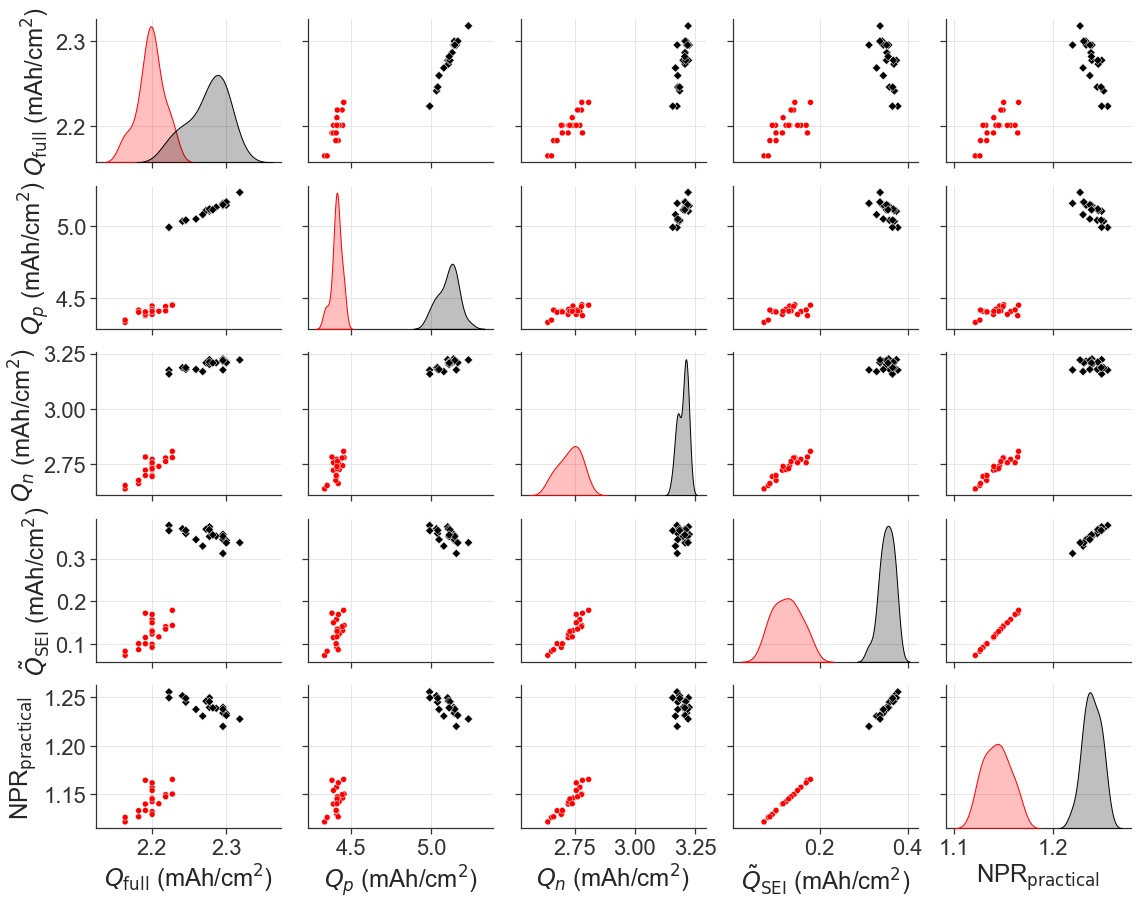

In [4]:
custom_params = {"grid.color" : "0.9",
                 "axes.facecolor" : "w",
                 "axes.edgecolor" : "0.2",
                 "xtick.color" : "0.2",
                 "xtick.bottom" : True,
                 "ytick.color" : "0.2",
                 "ytick.left" : True}

sns.set(font='Arial',
        font_scale=2,
        palette=['k', (1, 0, 0), (0, 0, 1)],
        color_codes=True,
        rc=custom_params)

vars_to_plot = ['Qfullnorm',
                'Cpnorm_full', 
                'Cnnorm_full', 
                'Qseinorm', 
                'npr']

# Generate the plot
g = sns.pairplot(df, vars=vars_to_plot,
                        hue='Source',
                        diag_kind='auto',
                        markers=['D', 'o'],
                        corner=False)

# Prettify axis labels
replacements = {'Qfullnorm': r'$Q_{\mathrm{full}}$ (mAh/cm$^2$)',
                'Cpnorm_full': r'$Q_p$ (mAh/cm$^2$)', 
                'Cnnorm_full': r'$Q_n$ (mAh/cm$^2$)',
                'Qseinorm': r'$\tilde{Q}_{\mathrm{SEI}}$ (mAh/cm$^2$)',
                'Clinorm': r'$Q_{\mathrm{Li}}$ (mAh/cm$^2$)',
                'npr': 'NPR$_{\mathrm{practical}}$',
                'x0' : '$x_0$',
                'y0' : '$y_0$'}

g._legend.remove()

for i in range(len(vars_to_plot)):
    for j in range(len(vars_to_plot)):
        try:
            xlabel = g.axes[i][j].get_xlabel()
        except:
            xlabel = '' 
        try:
            ylabel = g.axes[i][j].get_ylabel()
        except:
            ylabel = '' 
        
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

g.fig.savefig(f'{output_path}/fig_correlations_manufacturing.png', dpi=300)

# Box-and-Whisker Plot

Statistics for 'Qfullnorm':
Ttest_indResult(statistic=10.983407495282293, pvalue=8.274772790986802e-13)
---
Statistics for 'Cpnorm_full':
Ttest_indResult(statistic=45.768685652038634, pvalue=4.772049974622606e-29)
---
Statistics for 'Cnnorm_full':
Ttest_indResult(statistic=40.84900005026032, pvalue=1.133834831976874e-24)
---
Statistics for 'Qseinorm':
Ttest_indResult(statistic=29.02729419500934, pvalue=1.0400434608839761e-22)
---
Statistics for 'npr':
Ttest_indResult(statistic=27.25401467619547, pvalue=2.2528304381149703e-24)
---


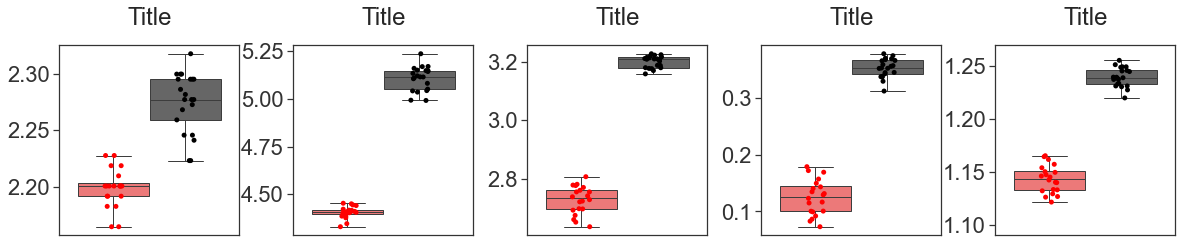

In [7]:

gridspec = dict(wspace=0.30, width_ratios=np.ones(len(vars_to_plot)))

fig, axs = plt.subplots(nrows=1, ncols=len(vars_to_plot),
                    gridspec_kw=gridspec,
                    figsize=(20, 3.5))

ylims = [None, None, None, None, (1.09, 1.27), (-0.01, 0.03), (0.88, 0.96)]

for var, ax, ylim in zip(vars_to_plot, axs, ylims):

    # Show the box and whisker plot        
    bp = sns.boxplot(x='Group', y=var,
                     data=df,
                     palette=[(0.4,0.4,0.4), (1,0.4,0.4), (0.4, 0.4, 1)],
                     hue='Source',
                     showfliers=False,
                     whis=1e9,
                     linewidth=1,
                     ax=ax
                    )

    # Show the markers
    bp = sns.stripplot(x='Group', y=var, 
                       data=df, 
                       jitter=True,
                       dodge=True, 
                       palette=[(0, 0, 0), (1,0,0), (0, 0, 1)],
                       marker='o',
                       hue='Source',
                       alpha=1, 
                       ax=ax)

    # Compute some basic statistics
    df1 = df[df['Source'] == 'Mohtat2021 (RT)']
    df2 = df[df['Source'] == 'Weng2021 (RT)']
    res = stats.ttest_ind(df1[var], df2[var], equal_var=False)
    print(f"Statistics for '{var}':")
    print(res)
    print(f"---")

    # Plot aesthetics
    bp.set(ylabel=None,
           xlabel=None)
    bp.set_title(replacements[var], pad=10)
    bp.tick_params(bottom=False)
    bp.get_legend().remove()
    
    ax.grid(False)
    ax.set_ylim(ylim)
    ax.invert_xaxis()
    

bp.get_figure().savefig(f'{output_path}/fig_correlations_manufacturing_boxplots.png', dpi=300, bbox_inches='tight')

# Some more summary statistics

In [6]:
df.groupby('Source').agg({'Qfullnorm': 'mean',
                          'Cpnorm' : 'mean',
                          'Cnnorm' : 'mean',
                          'Clinorm' : 'mean',
                          'npr': 'std', # practical NPR
                          'x0' : 'mean',
                          'y0' : 'mean',
                          'np_ratio' : 'std'}) # theoretical NPR (tilde ; estimated from observed Qp/Qn)

,Qfullnorm,Cpnorm,Cnnorm,Clinorm,npr,x0,y0,np_ratio
Source,,,,,,,,
Mohtat2021 (RT),2.275089,2.655568,2.701519,2.361808,0.008975,-0.000062,0.889325,0.008797
Weng2021 (RT),2.198773,2.460330,2.457902,2.344876,0.013155,0.019969,0.932890,0.014203
